In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import math


In [1]:
def show_mask(mask, ax):
    color = np.array([86/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   
    
def find_object_centers(image):
    # Load the image
    #image = cv2.imread(image_path)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    l_b = np.array([0, 0, 0])  # Lower bound for black color
    u_b = np.array([255, 255, 36])  # Upper bound for black color

    # Create a Mask with adaptive threshold
    mask = cv2.inRange(hsv, l_b, u_b)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    denoised = cv2.medianBlur(closing, 5)

    # Find contours
    contours, hierarchy = cv2.findContours(denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours by area
    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 2000 < area < 5000:
            filtered_contours.append(cnt)
    filtered_contours.sort(key=cv2.contourArea, reverse=True)

    # Get rectangles bounding the 8 largest contours and retrieve their centers
    objects_contours = filtered_contours[:8]
    center_points = []
    for i, cnt in enumerate(objects_contours):
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        center_points.append((center_x, center_y))

    return center_points


In [4]:
image = cv2.imread('images/duy1.jpg')
#Get the centers point
centers = find_object_centers(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)


(1239, 2048, 3)


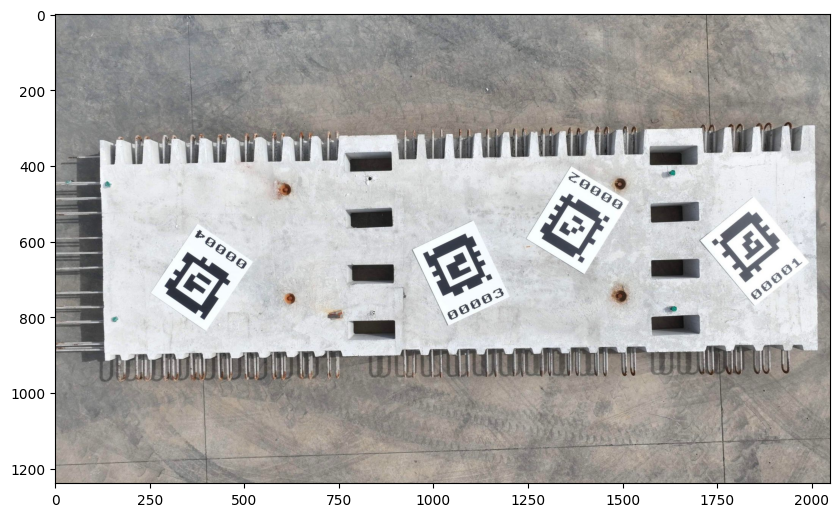

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [6]:
check_point = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor,SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "default"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [8]:
predictor.set_image(image)

In [9]:
input_point = np.array([[200+centers[0][0],centers[0][1]]])
input_label = np.array([1])

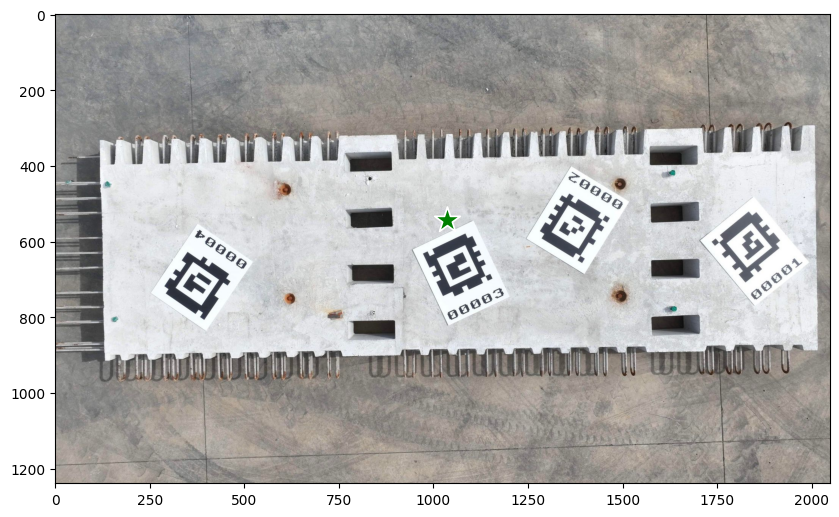

(1239, 2048, 3)

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 
image.shape

In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [12]:
masks.shape  # (number_of_masks) x H x W

(3, 1239, 2048)

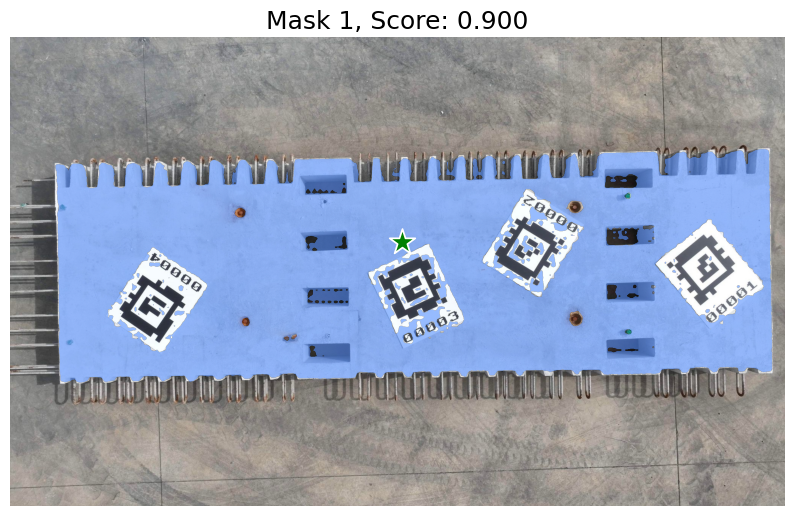

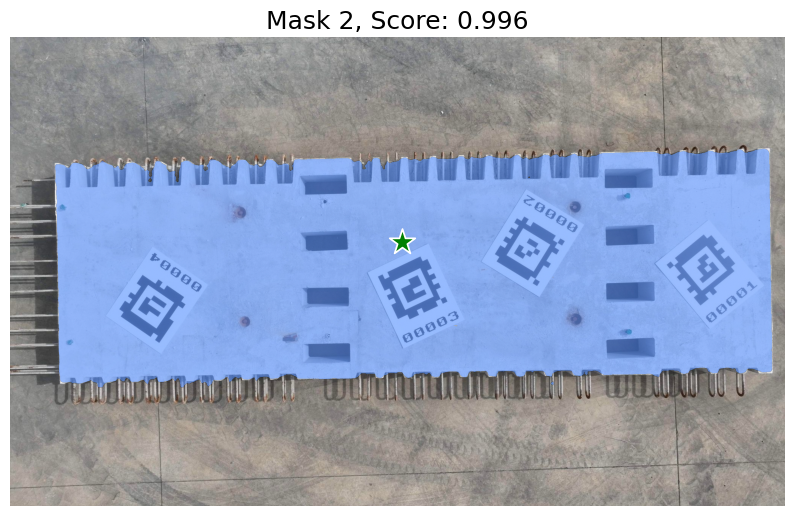

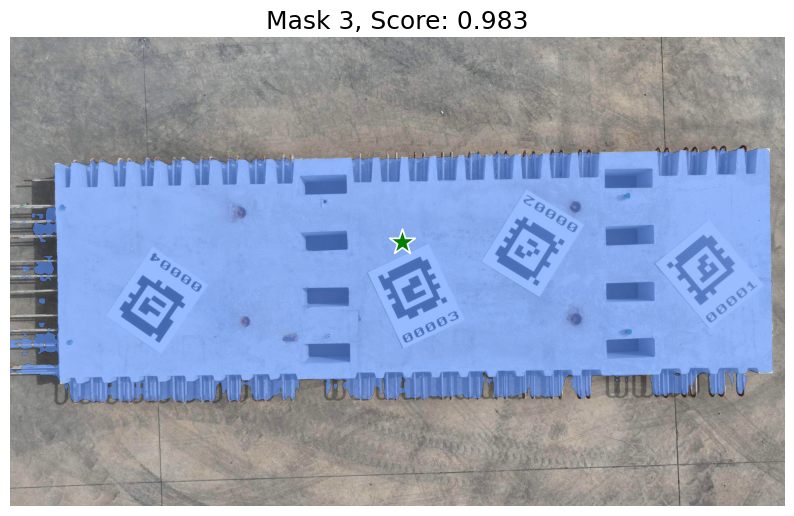

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
         
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    scorea = (score)
    plt.title(f"Mask {i+1}, Score: {scorea:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

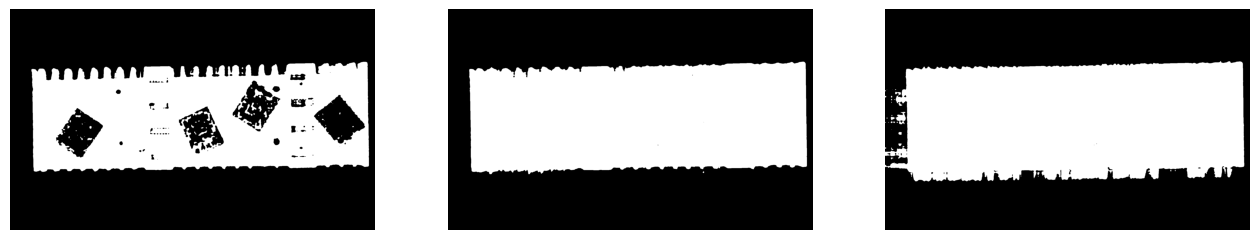

In [14]:
import supervision as sv

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)


[[ 115  410]
 [2020  366]
 [2037 1094]
 [ 132 1139]]


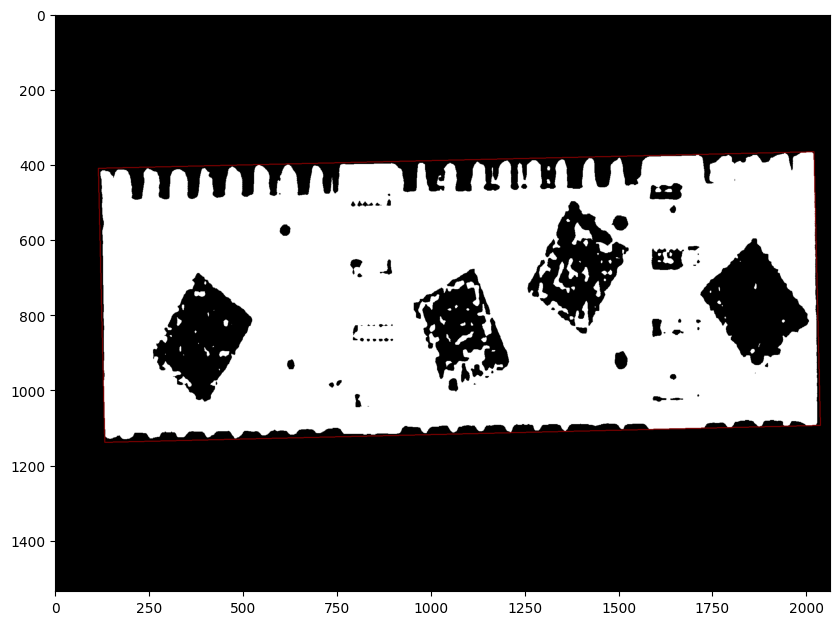

True

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have loaded the 'masks' array and 'mask_index' is defined
mask_index = 0
# Assuming masks[mask_index] contains the mask you want to resize

# Resize the mask to the desired dimensions (2063x1535 in this case)
resized_mask = cv2.resize(masks[mask_index].astype(np.uint8), (2063, 1535))

# Assuming the original mask is masks[1]
original_mask = masks[1].astype(np.uint8)  # Convert to uint8

# Multiply by 255 to get the binary representation
resized_maskA = resized_mask * 255

# Find contours in the binary mask image
contours, _ = cv2.findContours(resized_maskA, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
largest_contour = max(contours, key=cv2.contourArea)

# Draw a minimum area rectangle bounding box around the largest contour
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.intp(box)  # Use np.intp instead of np.int0
print(box)

# Draw the rectangle on a copy of the image
resized_mask_with_rect = cv2.cvtColor(resized_maskA, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels
cv2.drawContours(resized_mask_with_rect, [box], 0, (128, 0, 0), 2)  # Use blue color (BGR)

# Display the binary mask with the rectangle using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(resized_mask_with_rect, cmap='gray')
plt.show()

# Save the image with the rectangle as a binary file using OpenCV
cv2.imwrite("binarySAM1_with_rect.jpg", resized_mask_with_rect)



# Perspective Transformation

width: 1906 height: 729
[[ 9.98022652e-01 -2.32735049e-02 -1.05230468e+02]
 [ 2.30517068e-02  9.98034124e-01 -4.11844937e+02]
 [-7.18853244e-07  3.35680880e-08  1.00000000e+00]]
(1285, 2075, 3)


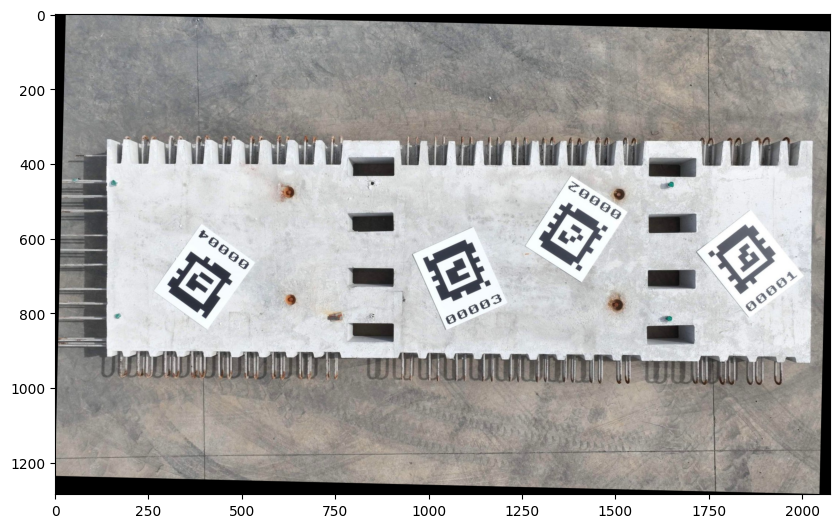

True

In [16]:
hh, ww = image.shape[:2]

# Specify input coordinates for corners of quadrilateral in order TL, TR, BR, BL as x, y
input = np.float32([box[0],box[1],box[2],box[3]])


# Get top and left dimensions and set them as the width and height of the output rectangle
width = round(math.hypot(input[0, 0] - input[1, 0], input[0, 1] - input[1, 1]))
height = round(math.hypot(input[0, 0] - input[3, 0], input[0, 1] - input[3, 1]))
print("width:", width, "height:", height)

# Set upper left coordinates for output rectangle
x = input[0, 0]
y = input[0, 1]

# Specify output coordinates for corners of quadrilateral in order TL, TR, BR, BL as x, y
output = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])

# Compute perspective matrix
matrix = cv2.getPerspectiveTransform(input, output)
print(matrix)

# Calculate the transformed coordinates of all four corners of the original image
original_corners = np.float32([[0, 0], [ww - 1, 0], [ww - 1, hh - 1], [0, hh - 1]])
transformed_corners = cv2.perspectiveTransform(np.array([original_corners]), matrix)[0]

# Find the minimum and maximum x and y values of the transformed coordinates
min_x = np.min(transformed_corners[:, 0])
max_x = np.max(transformed_corners[:, 0])
min_y = np.min(transformed_corners[:, 1])
max_y = np.max(transformed_corners[:, 1])

# Calculate the width and height of the bounding box for the transformed image
bbox_width = int(np.ceil(max_x - min_x))
bbox_height = int(np.ceil(max_y - min_y))

# Calculate the translation matrix to shift the bounding box to positive coordinates
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

# Apply the translation matrix to the perspective transformation matrix
final_matrix = translation_matrix.dot(matrix)

# Do perspective transformation using the final matrix
output_size = (bbox_width, bbox_height)
imgOutput = cv2.warpPerspective(image, final_matrix, output_size, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
print(imgOutput.shape)

plt.figure(figsize=(10, 10))
plt.imshow(imgOutput)
plt.show()

cv2.imwrite("Test2.jpg", imgOutput)
